# Sentiment Analysis

>### Today
>
>- [An Introduction to Sentiment Analysis](#An-Introduction-to-Sentiment-Analysis)
>
>
>- [Sentiment Classification](#Sentiment-Classification)
>
>
>- [Machine Learning Approaches](#Machine-Learning-Approaches)
>
>
>- [Lexicon-based Approaches](#Lexicon-based-Approaches)


If you have been doing the advanced PyTorch/BERT notebooks, you might want to try this tutorial for fine-tuning Llama 2 (a decoder model, new architecture for us) for sentiment analysis: https://www.kaggle.com/code/lucamassaron/fine-tune-llama-2-for-sentiment-analysis

This won't run on your laptop though! It requires a reasonably sized GPU of perhaps 8GB memory, depending on batch size.

Otherwise, we proceed in this notebook with nltk and scikit-learn.


---

In [1]:
import random

from collections import Counter

import nltk
import sklearn
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

from sklearn import naive_bayes, metrics

# plt.rcdefaults()
plt.rcParams['figure.figsize'] = (16, 10)

---

## An Introduction to Sentiment Analysis


**Sentiment Analysis** (also called Opinion Mining) is the computational study of people's opinions, attitudes and emotions toward an entity (a person, an object, an event, a topic) expressed in a text.

- SA is difficult because it is often:

    - necessary to include word knowledge;

    - necessary to have some (basic) model of how emotions work.

### Why Sentiment Analysis?

- **Business and Organizations**: how do consumers feel about a product and its features? Where is the market going?



- **Ad placement**: show an ad for product $x$ to users who expressed positive sentiments on products similar to $x$, e.g. in social media posts.



- **Individuals**: what product may a user like/dislike? What other users share similar feelings towards a given entity?



- **Politics**: what to people think about a candidate or an issue? What is going to be the outcome of an election?

### Key Concepts

> **Credits**: The following section is based on Liu (2010) Sentiment Analysis and Subjectivity. In Indurkhya & Damerau (eds.) *Handbook of Natural Language Processing*, CRC Press: Chapter 26.

(1). *I bought an iPhone a few days ago.* 
    - a fact, not an opinion


(2). *It was such a nice phone.*
    - positive opinion
    - on the phone as a whole
    - from the author of the review


(3). *The touch screen was really cool.*
    - positive opinion
    - on a component of the phone
    - from the author of the review


(4). *The voice quality was clear too.* 
    - positive opinion
    - on a characteristic of the phone
    - from the author of the review


(5). *Although the battery life was not long, that is ok for me.*
    - negative opinion?
    - on another characteristic of the phone
    - from the author of the review


(6). *However, my mother was mad with me as I did not tell her before I bought it.*
    - negative emotion/opinion
    - towards the author of the review
    - from the mother of the author of the review


(7). *She also thought the phone was too expensive, and wanted me to return it to the shop.*
    - negative opinion
    - on a characteristic of the phone
    - from the mother of the author of the review
    

**Definition of Objects**:

An object $o$ is an entity that can be a product, person, event, organization, or topic. It is associated with a pair $o : (T, A)$, where $T$ is a hierarchy of components (or parts), subcomponents, and so on, and $A$ is a set of attributes of $o$. Each component has its own set of subcomponents and attributes.

An opinion can be expressed on the object as a whole, on one or several of its components, or on one or several of the attributes.

> **Example**:
>
>A particular cell phone model by some phone manufacturer is an object. It has a set of components, e.g., *battery*, and *screen*, and also a set of attributes, e.g., *voice quality*, *size*, and *weight*. The battery component also has its set of attributes, e.g. *battery life* and *battery replacement ease*.

Often, the distinction between attributes and components is ignored in order to facilitate the task, and both concepts are referred to simply as **object features**.

**Definition of Opinion**:

An opinion on a feature f is a positive or negative view, attitude, emotion, or appraisal on f from an opinion holder:


- **polarity** (a.k.a.) opinion orientation: The *orientation* of an opinion on a feature f indicates whether the opinion is positive, negative, or neutral.


- **emotion**: *subjective feelings and thoughts*. Over the years, many [categorizations of emotions](https://en.wikipedia.org/wiki/Contrasting_and_categorization_of_emotions) have been proposed, e.g., Plutchik's "8 basic emotions" (acceptance, anger, anticipation, disgust, joy, fear, sadness, surprise).


- **opinion holder**: *the person or organization that expresses the opinion*
    - in the case of product reviews and blogs, opinion holders are usually the authors of the posts;
    - sometimes (e.g., in a news article, in example (6) above), the person or organization that holds a particular opinion is explicitely mentioned.

### Sentiment Analysis Text Mining Tasks

- **Sentiment Classification**: classify the opinions expressed in a text or a document as mostly positive, negative or neutral.
    - Opinions can be measured on different scales, e.g., {-1, 0, 1} or 5 star ratings.
    


- **Subjectivity Classification**: detect if a text contains only factual content or if it expresses some personal feelings, beliefs, emotions, evaluations, opinions.



- **Opinion Summarization**: summarize the opinions generated by describing a specific entity.
    - Feature-based opinion summarization: summarize the opinions for the main evaluated aspects of a given entity.
    - Single-document vs. multi-document.



- **Opinion Retrieval**: retrieve documents that expresses an opinion about an entity of interest (and/or about some of its characteristics).



- **Emotion Detection**: extract the emotions that are implicitly or explititly express in a text.



- **Sarcasm/Irony Detection**: identify ironic or sarcastic statements.
    - NB: it is difficult to define irony and/or sarcasm.



- **Opinion Spam Detection**: identify messages or reviews which contains contents whose main intent is to distort the public perception of an entity.

---

## Sentiment Classification

In general it is approached as **the classification the opinions expressed in a text or a document as mostly positive, negative or neutral**.

Source: [Methad et al. (2014)](http://www.sciencedirect.com/science/article/pii/S2090447914000550).

In the following exercises we will experiment with the Movie Reviews in the Sentiment Polarity Dataset by Pang & Lee (2004):

In [2]:
# credits and infos
print(nltk.corpus.movie_reviews.readme())

Sentiment Polarity Dataset Version 2.0
Bo Pang and Lillian Lee

http://www.cs.cornell.edu/people/pabo/movie-review-data/

Distributed with NLTK with permission from the authors.


Introduction

This README v2.0 (June, 2004) for the v2.0 polarity dataset comes from
the URL http://www.cs.cornell.edu/people/pabo/movie-review-data .


What's New -- June, 2004

This dataset represents an enhancement of the review corpus v1.0
described in README v1.1: it contains more reviews, and labels were
created with an improved rating-extraction system.


Citation Info 

This data was first used in Bo Pang and Lillian Lee,
``A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization 
Based on Minimum Cuts'',  Proceedings of the ACL, 2004.

@InProceedings{Pang+Lee:04a,
  author =       {Bo Pang and Lillian Lee},
  title =        {A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts},
  booktitle =    "Proceedings of the ACL",
  year =      

In [3]:
# how many reviews are we working with?
print(len(nltk.corpus.movie_reviews.fileids()))

2000


In [5]:
# they tend to be quite long
print(np.average([len(nltk.corpus.movie_reviews.words(fid)) for fid in nltk.corpus.movie_reviews.fileids()]), 
      "words per review on average.")

791.91 words per review on average.


In [6]:
# all reviews are assumed to be 'opinionated', ie fall under either 'positive' or 'negative' labels
print(nltk.corpus.movie_reviews.categories())

['neg', 'pos']


In [7]:
# example of a positive review
print(" ".join(nltk.corpus.movie_reviews.words(nltk.corpus.movie_reviews.fileids("pos")[0])[:100]))
print("\n[...]\n")
print(" ".join(nltk.corpus.movie_reviews.words(nltk.corpus.movie_reviews.fileids("pos")[0])[-100:]))

films adapted from comic books have had plenty of success , whether they ' re about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there ' s never really been a comic book like from hell before . for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid ' 80s with a 12 - part series called the watchmen . to say moore and campbell

[...]

, with the dreamy depp turning in a typically strong performance and deftly handling a british accent . ians holm ( joe gould ' s secret ) and richardson ( 102 dalmatians ) log in great supporting roles , but the big surprise here is graham . i cringed the first time she opened her mouth , imagining her attempt at an irish accent , but it actually wasn ' t half bad . the film , however , is all good . 2 : 00 - r for strong violence / gore , sexuality , language and drug content


In [8]:
# example of a negative review
print(" ".join(nltk.corpus.movie_reviews.words(nltk.corpus.movie_reviews.fileids("neg")[0])[:100]))
print("\n[...]\n")
print(" ".join(nltk.corpus.movie_reviews.words(nltk.corpus.movie_reviews.fileids("neg")[0])[-100:]))

plot : two teen couples go to a church party , drink and then drive . they get into an accident . one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . what ' s the deal ? watch the movie and " sorta " find out . . . critique : a mind - fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . which is what makes this review an even harder one to

[...]

also wrapped production two years ago and has been sitting on the shelves ever since . whatever . . . skip it ! where ' s joblo coming from ? a nightmare of elm street 3 ( 7 / 10 ) - blair witch 2 ( 7 / 10 ) - the crow ( 9 / 10 ) - the crow : salvation ( 4 / 10 ) - lost highway ( 10 / 10 ) - memento ( 10 / 10 ) - the others ( 9 / 10 ) - stir of echoes ( 8 / 10 )


#### Pre-process our reviews

Our documents are already sentence-splitted and tokenized, so that we will:

- lemmatize and PoS tag the words in each document


- remove punctuation and remove stopwords (we use `nltk.corpus.stopwords.words('english')`)


- split our documents into a training (80%) and a test (20%) set

In [9]:
# let's assign 20%  of our documents to the test set
test_ids = set()

for polarity in ["pos", "neg"]:
    test_ids.update(random.sample(nltk.corpus.movie_reviews.fileids(polarity), \
                                  int(0.2 * len(nltk.corpus.movie_reviews.fileids(polarity)))))

In [10]:
training_docs = dict((k,[]) for k in ["pos", "neg"])
test_docs = dict((k,[]) for k in ["pos", "neg"])

un2wn_mapping = {"VERB" : wn.VERB, "NOUN" : wn.NOUN, "ADJ" : wn.ADJ, "ADV" : wn.ADV}

stopwords = set(nltk.corpus.stopwords.words('english'))

# This might take a while, mainly because of the NLTK pos_tag call(s)
for polarity in ["pos", "neg"]:
    for did in nltk.corpus.movie_reviews.fileids(polarity):
        pdoc = []
        for w, p in nltk.pos_tag(nltk.corpus.movie_reviews.words(did), tagset="universal"):
            if p in [".", "X"]:  # filtering
                continue
            elif w.lower() in stopwords:
                if w.lower() in ["not", "t", "no"]:  # to handle negation
                    lemma = w.lower()
                    p = "NEGATION"
                else:  # filtering stopwords
                    continue
            elif p in un2wn_mapping:
                lemma = nltk.WordNetLemmatizer().lemmatize(w.lower(), pos = un2wn_mapping[p])
            else:
                lemma = nltk.WordNetLemmatizer().lemmatize(w.lower())
                
            pdoc.append("-".join([lemma, p]))
            
        if did in test_ids:
            test_docs[polarity].append(pdoc)
        else:
            training_docs[polarity].append(pdoc)

In [12]:
# our positive review example from above, lemmatized and PoS tagged (and below, the original for comparison)
print(test_docs["pos"][0][:50], "\n\n[...]\n")
print(" ".join(nltk.corpus.movie_reviews.words(nltk.corpus.movie_reviews.fileids("pos")[1])[:100]))

['every-DET', 'movie-NOUN', 'come-VERB', 'along-ADV', 'suspect-ADJ', 'studio-NOUN', 'every-DET', 'indication-NOUN', 'stinker-NOUN', 'everybody-NOUN', 'surprise-NOUN', 'perhaps-ADV', 'even-ADV', 'studio-NOUN', 'film-NOUN', 'become-VERB', 'critical-ADJ', 'darling-NOUN', 'mtv-ADJ', 'film-NOUN', "'-PRT", '_election-NOUN', 'high-ADJ', 'school-NOUN', 'comedy-NOUN', 'star-VERB', 'matthew-NOUN', 'broderick-NOUN', 'reese-ADJ', 'witherspoon-NOUN', 'current-ADJ', 'example-NOUN', 'anybody-NOUN', 'know-VERB', 'film-NOUN', 'exist-VERB', 'week-NOUN', 'open-VERB', 'plot-NOUN', 'deceptively-ADV', 'simple-ADJ', 'george-VERB', 'washington-ADJ', 'carver-NOUN', 'high-ADJ', 'school-NOUN', 'student-ADJ', 'election-NOUN', 'tracy-NOUN', 'flick-NOUN'] 

[...]

every now and then a movie comes along from a suspect studio , with every indication that it will be a stinker , and to everybody ' s surprise ( perhaps even the studio ) the film becomes a critical darling . mtv films ' _election , a high school comedy s

---

### Supervised Techniques: Naïve Bayes

According to the literature, the most reliable features for SC are:


- **Terms and their Frequency**: words or n-grams and their frequency. Raw counts, binary features or weighted counts (e.g., with TF-IDF) have been tested.


- **Part-of-Speech tags**: soon enough it became evident that some PoS (expecially adjectives) are important indicators of subjectivity and opinion, so they should be treated as special features. 


- **Opinion words and phrases**: some words or phrases have a strong connotation (i.e., they are regularly used to express a strong sentiment): e.g., *beautiful*, *amazing*, *terrible*. This is true also for noun and verbs (e.g., *crap*, *rubbish*, *hate*), and idioms (e.g. *what a trainwreck!*).


- **Syntactic dependency**: the syntactic relations in a sentence may be useful, e.g., to define the scope of an adjective (e.g., *amazing crap*) or of the negation (see below).


- **Negation**: negation often reverse the polarity of an expression: "I don’t like this camera" is negative. However, negation itself has a scope and this rule has many possible exceptions: e.g., "not only dumb but also boring" is a case of negation that does not change the polarity.


- **Emoticons**: expecially when working with quickly written, informal text (e.g., tweets, SMSs, etc.) the presence and the polarity of an emoticon is a relevant feature for polarity classification.

#### Feature Extraction

For this exercise, we consider a simple method that relies solely on the raw frequency of frequent **adjectives, adverbs and negation**.

First of all, let's check the frequency of our features:

In [15]:
candidate_features = Counter()

for p in ["pos", "neg"]:
    for doc in training_docs[p]:
        for w in doc:
            if w.split("-")[-1] in ["ADJ", "ADV", "NEGATION"]:
                candidate_features[w] += 1

print("candidate features:", len(candidate_features))

candidate features: 12146


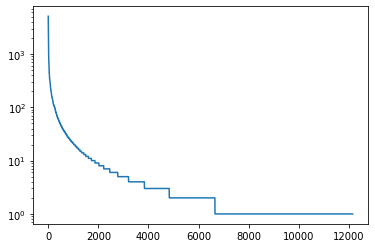

In [16]:
x = np.arange(1, len(candidate_features) + 1)
y = np.array([v for _, v in candidate_features.most_common()])

plt.plot(x, y)

plt.yscale('log') 

plt.show()

Let's filter out all those lemmas that occur less than 10 times:

In [17]:
features = dict()

for idx, (f, v) in enumerate(candidate_features.most_common()):
    if v == 9:
#         print(idx, f, v)
        break

    features[f] = idx
    
print("selected features:", len(features))

selected features: 1862


Using these features, let's build:

- a document (rows) x features (columns) matrix encoding the raw frequencies 


- a vector encoding, for each document, its polarity (0 = "negative", 1 = "positive")

In [18]:
fMat = np.zeros((sum([len(v) for v in training_docs.values()]), len(features)))
labelsVec = np.zeros((sum([len(v) for v in training_docs.values()])))

docId = 0
for polarity in ["neg", "pos"]:
    for doc in training_docs[polarity]:
        if polarity == "pos":
            labelsVec[docId] = 1

        for word in doc:
            if word in features:
                fMat[docId, features[word]] += 1

        docId += 1

#### Classification

We experiment with Naive Bayes for multinomially distributed data implemented in the scikit-learn `naive_bayes.MultinomialNB()` class.

- This algorithm is suitable for classification with discrete features (e.g., word counts).

In [19]:
clf = naive_bayes.MultinomialNB()

Let's build our model by submitting our document/feature matrix and our correct labels

In [20]:
clf.fit(fMat, labelsVec)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### Evaluation

To evaluate the quality of our model we perform (i.e. **predict**) the annotation of the **test set** (for which we have the correct annotation) and we calculate (reminder!):

**Accuracy**: the percentage of inputs documents correctly classified.

**Precision, Recall and F-measure** are calculated from the following estimates:

- True Positives: items that we correctly identified as positive.
- True Negatives: items that we correctly identified as negative.
- False Positives (or Type I errors): negative items that we incorrectly identified as positive.
- False Negatives (or Type II errors): positive items that we incorrectly identified as negative.

- **Precision**: how many of the items that we identified were relevant: $\frac{\text{TP}}{(\text{TP}+\text{FP})}$.


- **Recall**: ow many of the relevant items that we identified, is $\frac{\text{TP}}{(\text{TP}+\text{FN})}$,


- **F$_1$-measure**: the harmonic mean of the precision and recall: $2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

First, extract the features from the test set (and create a vector for the gold standard)

In [21]:
testMat = np.zeros((sum([len(v) for v in test_docs.values()]), len(features)))
goldStandard = np.zeros((sum([len(v) for v in test_docs.values()])))

docId = 0
for polarity in ["neg", "pos"]:
    for doc in test_docs[polarity]:
        if polarity == "pos":
            goldStandard[docId] = 1

        for word in doc:
            if word in features:
                testMat[docId, features[word]] += 1

        docId += 1

Next, annotate the test set with our previously trained model:

In [22]:
predicted = clf.predict(testMat)

Then, calculate our evaluation metrics:

In [23]:
# accuracy
print("accuracy:", metrics.accuracy_score(predicted, goldStandard))

accuracy: 0.8225


In [24]:
# precision, recall and f-measure
print("precision:", metrics.precision_score(predicted, goldStandard))

print("recall:", metrics.recall_score(predicted, goldStandard))

print("f1-measure:", metrics.f1_score(predicted, goldStandard))

precision: 0.785
recall: 0.8486486486486486
f1-measure: 0.8155844155844156


---

##### Question

Why are the accuracy and precision results different? Can you cast accuracy in terms of the precision formula above?

##### Question

See what happens to your classifier if you use term frequency-inverse document frequency (tf-idf) to weight the raw frequencies


- Recall that tf-idf is a composite weight for each term $t$ in each document $d$, estimated as:

$$\text{tf-idf}_{t,d} = \text{tf}_{t,d} \times \text{idf}_t = \text{tf}_{t,d} \times log \left( \frac{N}{\text{df}_t}\right)$$

- tf$_{t,d}$ is the number of occurrence of $t$ in $d$
- $N$ is the total number of documents
- df$_t$ is the number of documents in which $t$ appears

In [ ]:
# your code here

---

### Lexicon-based Approaches (optional)

Lexicon based approaches derive the polarity of a word (or of a phrase) from a sentiment lexicon. In their base form, LB approaches classify a document by summing up all sentiment expressions in the document.


- Sentiment lexicon: a collection of known sentiment terms, phrases and even idioms annotated for their sentiment.



- These resources can be created **manually** or **automatically**.



- In their simplest form, these resources are lists of positive/negative words, but more recent resources tend to associated **gradable scores** to each entry.

The oldest sentiment lexicon is the [General Inquirer](http://www.wjh.harvard.edu/~inquirer/) (Stone et al., 1966):


- drews on work in psycholinguistics (Osgood et al., 1957) and on work in content analysis


- lexicon of 1915 positive words and 2291 negative words


The [MPQA Subjectivy lexicon](http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/) (Wilson et al., 2005) is derived by combining several resource:

- 2718 positive and 4912 negative words

The [polarity lexicon](http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar) by Hu and Liu (2004) consisting of lists of strings:

- drawn from product reviews, labeled using a bootstrapping method from WordNet


- 2006 positive and 4783 negative words


**Some sample words with consistent sentiment across these three sentiment lexicons** (from Jurafsky & Marin (2018):

>**Positive**: `admire, amazing, assure, celebration, charm, eager, enthusiastic, excellent, fancy, fantastic, frolic, graceful, happy, joy, luck, majesty, mercy, nice, patience, perfect, proud, rejoice, relief, respect, satisfactorily, sensational, super, terrific, thank, vivid, wise, wonderful, zest`.
>
>
>**Negative**: `abominable, anger, anxious, bad, catastrophe, cheap, complaint, condescending, deceit, defective, disappointment, embarrass, fake, fear, filthy, fool, guilt, hate, idiot, inflict, lazy, miserable, mourn, nervous, objection, pest, plot, reject, scream, silly, terrible, unfriendly, vile, wicked`.

#### SentiWordNet

[SentiWordNet](https://github.com/aesuli/sentiwordnet) is a lexical resource in which each WordNet synset is associated to three numerical scores describing how objective, positive, and negative the terms contained in the synset are.

- The semi-supervised method used to develop SentiWordNet is based on:

    - the manual annotation of two sets of seeds (positive and negative terms) and their expansion on the basis of the synonym and antonymy relations encoded in WordNet;
    - the quantitative analysis of the glosses associated to synsets, and on the use of the resulting vectorial term representations for semi-supervised synset classification. The basic assumption is that  terms with similar polarity tend to have "similar" glosses.


- The three scores are derived by combining the results produced by a committee of eight ternary classifiers, all characterized by similar accuracy levels but different classification behaviour.


- Due to the synset-based nature of the WordNet representation, given that this lexical resource provides a synset-based sentiment representation, different senses of the same term may have different sentiment scores.

#### Retrieving Synsets

The easiest way to retrieve synsets is by submitting the relevant lemma to the `senti_synsets()` method, that returns the list of all the synsets containing it:

In [33]:
# Download the sentiwordnet data (only needed once...)
nltk.download('sentiwordnet')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/giovannicolavizza/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [26]:
print(list(swn.senti_synsets('slow')))

[SentiSynset('decelerate.v.01'), SentiSynset('slow.v.02'), SentiSynset('slow.v.03'), SentiSynset('slow.a.01'), SentiSynset('slow.a.02'), SentiSynset('dense.s.04'), SentiSynset('slow.a.04'), SentiSynset('boring.s.01'), SentiSynset('dull.s.08'), SentiSynset('slowly.r.01'), SentiSynset('behind.r.03')]


The optional paramater `pos` allows you to constrain the search to a given part of speech 

- available options: `wn.NOUN`, `wn.VERB`, `wn.ADJ`, `wn.ADV` (require wordnet)

In [27]:
print(list(swn.senti_synsets('happy', pos = wn.ADJ)))

[SentiSynset('happy.a.01'), SentiSynset('felicitous.s.02'), SentiSynset('glad.s.02'), SentiSynset('happy.s.04')]


If you want to access all the synset in the resource, you can call the `all_senti_synsets()` method

In [28]:
len(list(swn.all_senti_synsets()))

117659

You can use the `senti_synset()` method together with the notation `lemma.pos.numer` (e.g. `breakdown.n.03`) to access a given synset (or to refer to its annotation)

In [29]:
breakdown = swn.senti_synset('breakdown.n.03')
print(breakdown)

<breakdown.n.03: PosScore=0.0 NegScore=0.25>


#### Retrieving Scores

The methods `pos_score()`, `neg_score()` and `obj_score()` can be called to retrieve the sentiment scores associated with a given synset:

In [30]:
breakdown.pos_score()

0.0

In [31]:
breakdown.neg_score()

0.25

In [32]:
breakdown.obj_score()

0.75

---

##### Question

Use the following simple strategy:

- for each word in a document, retrieve all the synsets available in SentiWordNet;


- average across all the senses that are associated with a given lemma;


- calculate the polarity of the whole document as the sum of the polarity of its words;


- see how things change if you filter out the words with a low subjective score;


- compare with the Naive Bayes method in terms of accuracy, precision, recall.

In [ ]:
# your code here

---